# Initial Setup
Load data from "music_genre.csv" in folder using pandas. Save the data frame back to SQLite; leveraging mostly SQL for analysis. Plot items using pyplot from matlab.

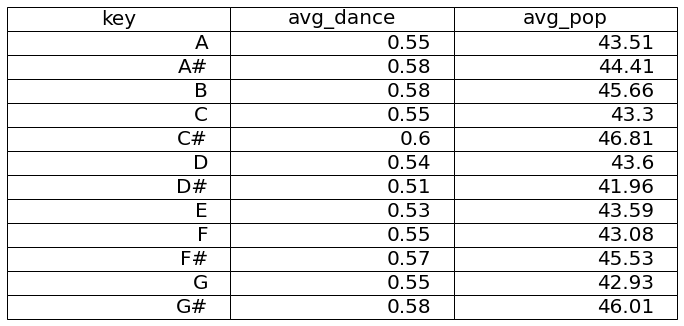

In [40]:
import matplotlib.pyplot as plt
import pandas as pd
import pandasql as ps
import sqlite3
import numpy as np

# read csv
music_genre = pd.read_csv('music_genre.csv')

# create an in-memory sqlite database and save the data frame to it
conn = sqlite3.connect(":memory:")
music_genre.to_sql(name='music', con=conn)
cur = conn.cursor()

query = """SELECT 
                key,
                ROUND(AVG(danceability), 2) avg_dance, 
                ROUND(AVG(popularity), 2) avg_pop
            FROM 
                music
            WHERE
                danceability IS NOT NULL
            AND
                popularity IS NOT NULL                 
            GROUP BY 
                key"""

# grab average danceability, popularity, and key from the table we just created
# we'll use this later in the plots below
cur.execute(query)
avg_result = cur.fetchall()

avg_danceability = []
avg_popularity = []
avg_song_key = []

# iterate over the rows return and account for NULLs in the results
for row in avg_result:
    item_key = row[0]
    if item_key is None:
        avg_song_key.append("?")
    else:
        avg_song_key.append(item_key)
    item_dancebility = row[1]
    if item_dancebility is None:
        avg_danceability.append(0)
    else: 
        avg_danceability.append(item_dancebility)
    item_pop = row[2]    
    if item_pop is None:
        avg_popularity.append(0)
    else:
        avg_popularity.append(item_pop)
   
# show table of results
df = pd.read_sql(query, conn)

# attempt to create a backing color table
#color_df = ps.sqldf("SELECT 1, avg_dance, avg_pop from df")
#colVal = np.around(color_df, 2)
#norm = plt.Normalize(colVal['avg_dance'].min(), colVal['avg_pop'].max())
#colors = plt.cm.hot(norm)

# https://www.statology.org/matplotlib-table/
fig, ax = plt.subplots()
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

#table = ax.table(cellText=df.values, colLabels=df.columns, loc='center', cellColours=colors)
table = ax.table(cellText=df.values, colLabels=df.columns, loc='center')

# https://stackoverflow.com/questions/15514005/how-to-change-the-tables-fontsize-with-matplotlib-pyplot
table.set_fontsize(20)
table.scale(2, 2)
plt.show()   

# Average Danceability versus Song Key

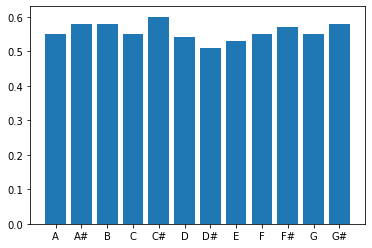

In [41]:
plt.bar(avg_song_key, avg_danceability)
plt.show()

# Average Popularity versus Song Key


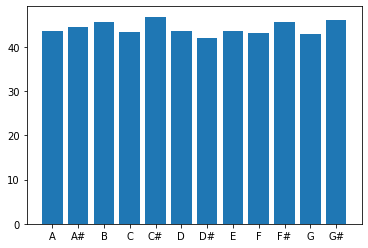

In [42]:
plt.bar(avg_song_key, avg_popularity)
plt.show()

# Breakdown by Key
Looking at min, max, and average for every key.

## Code

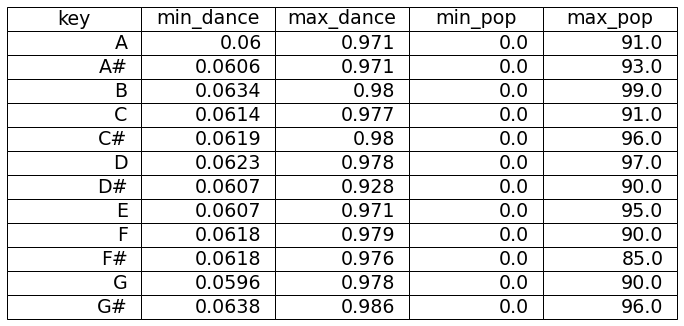

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# grab danceability, popularity, and key from the table we just created
query = """SELECT 
            key,
            MIN(danceability) min_dance, 
            MAX(danceability) max_dance, 
            MIN(popularity) min_pop, 
            MAX(popularity) max_pop
        FROM 
            music
        WHERE
            danceability IS NOT NULL
        AND
            popularity IS NOT NULL                     
        GROUP BY 
            key"""

# print(pd.read_sql_query(query, conn))
df = pd.read_sql(query, conn)

# https://www.statology.org/matplotlib-table/
fig, ax = plt.subplots()
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

table = ax.table(cellText=df.values, colLabels=df.columns, loc='center')
table.set_fontsize(20)
table.scale(2, 2)
plt.show()

